# RNN for Human Activity Recognition
# Import required libraries

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from random import randint
import time
import os
import json

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = '/content/gdrive/My Drive/Deep Learning/MHAD/'

# Load Dataset

In [0]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"
] 

# LABELS = [    
#     "NO_CLAPPING",
#     "CLAPPING_HANDS"
# ]

X_train_path = data_path + "X_train.txt"
X_test_path = data_path + "X_test.txt"

y_train_path = data_path + "Y_train.txt"
y_test_path = data_path + "Y_test.txt"

# No. of timesteps per series
n_steps = 32 

In [0]:
# Load the Inputs
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array([elem for elem in [row.split(',') for row in file]], dtype=np.float32)
    file.close()
    blocks = int(len(X_) / n_steps)
    X_ = np.array(np.split(X_,blocks))
    return X_ 

# Load the Labels
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array([elem for elem in [row.replace('  ', ' ').strip().split(' ') for row in file]], dtype=np.int32)
    file.close()
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# Set Parameters

In [0]:
# Input Data 
training_data_count = len(X_train) # No. of training inputs 22625
test_data_count = len(X_test)  # No. of test inputs 5751
n_input = len(X_train[0][0])  # No. of input parameters per timestep

n_hidden = 34 # Hidden layer num of features
n_classes = 6 # No. of output classes/labels
# n_classes = 2 # No. of output classes/labels

# Learning rate (exponential) decay calculated as 
# decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 # Used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 # The base of the exponential in the decay
decay_steps = 100000 # Used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = 4.0e4  # 0.05 million epochs of training
batch_size = 128
display_iter = 1e3  # To show test set accuracy during training

# Utility functions

In [0]:
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # ReLU activation function
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    # With dropout prob of 0.5 
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    # lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell] * 2, state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    outputs = tf.contrib.layers.batch_norm(outputs)

    lstm_last_output = outputs[-1]
    
    # Linear activation
    # return tf.add(tf.matmul(lstm_last_output, _weights['out']), _biases['out'], name='Pred')
    pred = tf.matmul(lstm_last_output, _weights['out']) + _biases['out']
    return pred


def extract_batch_size(_train, _labels, batch_size):
    # Fetch a "batch_size" amount of data and labels from training data.   
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    idx = random.sample(range(0, len(_train)), batch_size)
    batch_s = _train[idx]
    batch_labels = _labels[idx]
    return batch_s, batch_labels


def one_hot(y_):
    # One hot encoding of the network outputs
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# Build the RNN model


In [11]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name='x')
y = tf.placeholder(tf.float32, [None, n_classes], name='y')

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden]), name='W1'), 
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0), name='W2')
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden]), name='b1'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='b2')
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 regularization to prevent overfitting
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='Accuracy')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Train the model

In [12]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Save the model
saver = tf.train.Saver()

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train
step = 0
time_start = time.time()

while step <= training_iters:
    batch_xs, raw_labels = extract_batch_size(X_train, y_train, batch_size)
    batch_ys = one_hot(raw_labels)
    # Check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if step % display_iter == 0:
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")
time_stop = time.time()
print("TOTAL TIME for TRAINING: {}".format(time_stop - time_start))
saver.save(sess, 'RNN_Model_Trained.ckpt')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Iter #0:  Learning rate = 0.005000:   Batch Loss = 15.854206, Accuracy = 0.1640625
PERFORMANCE ON TEST SET:             Batch Loss = 10.416271209716797, Accuracy = 0.13893236219882965
Iter #1000:  Learning rate = 0.004800:   Batch Loss = 2.297036, Accuracy = 0.2734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3199713230133057, Accuracy = 0.2712571620941162
Iter #2000:  Learning rate = 0.004608:   Batch Loss = 2.105799, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0991098880767822, Accuracy = 0.21231089532375336
Iter #3000:  Learning rate = 0.004424:   Batch Loss = 1.971559, Accuracy = 0.1796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9318666458129883, Accuracy = 0.22830812633037567
Iter #4000:  Learning rate = 0.004077:   Batch Loss = 1.849991, Accuracy = 0.1796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8317829370498657, Accuracy = 0.22

'RNN_Model_Trained.ckpt'

In [13]:
# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run([pred, accuracy, cost], feed_dict={x: X_test, y: one_hot(y_test)})

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT:" + "Batch Loss = {}".format(final_loss) + ", Accuracy = {}".format(accuracy))

FINAL RESULT:Batch Loss = 0.13068974018096924, Accuracy = 0.9739176034927368


# Plot the results

42
40001


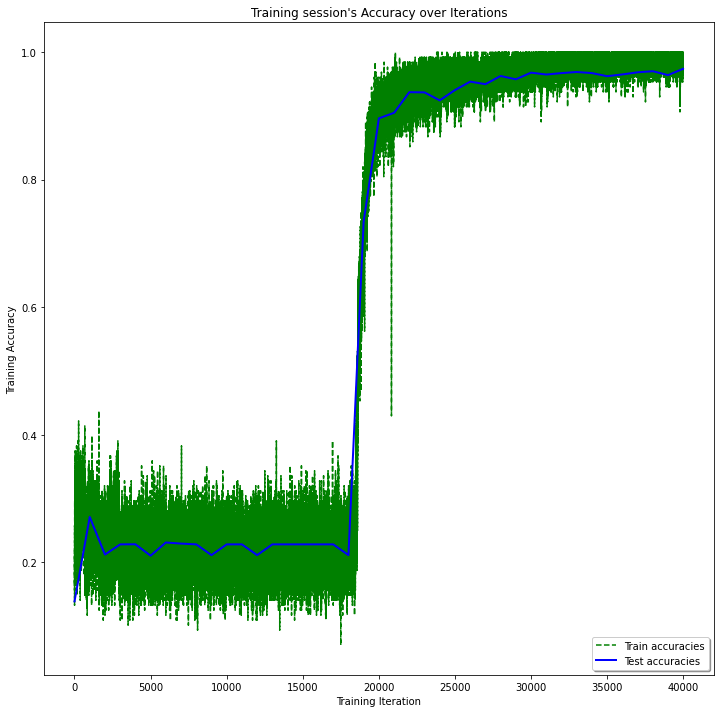

Testing Accuracy: 97.39176034927368%

Precision: 97.39855806274277%
Recall: 97.39175795513823%
f1_score: 97.39308551250217%

Confusion Matrix:
Created using test set of 5751 datapoints, normalised to % of each class in the test dataset


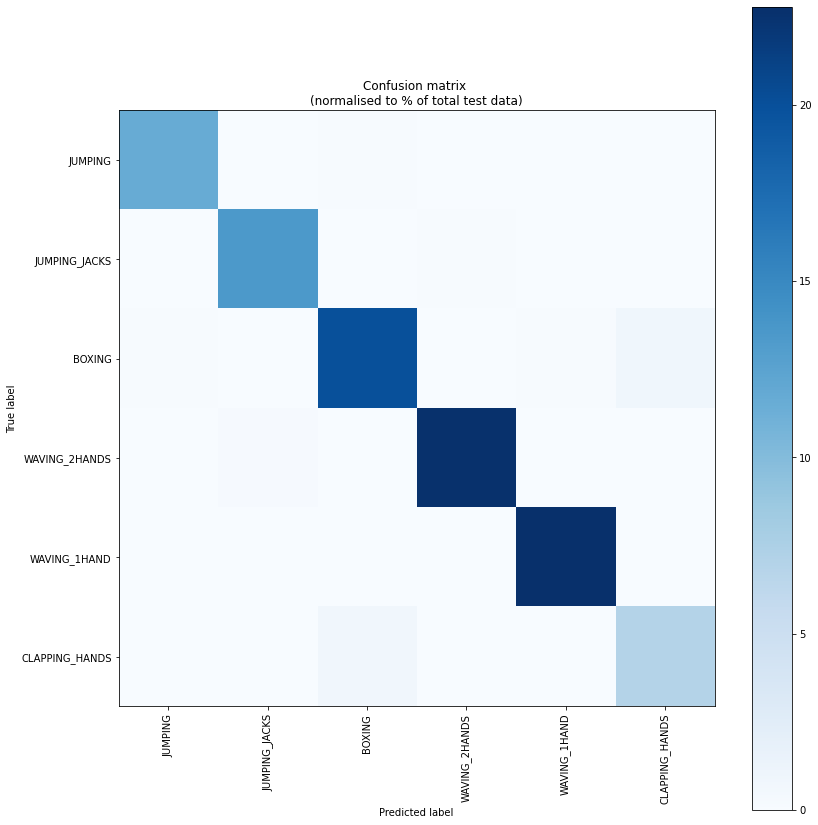

In [14]:
width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(1, (len(train_losses)+1)))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(1, len(test_losses)*int(display_iter), int(display_iter))[:-1]),[training_iters])

plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')
plt.savefig('Acc.jpeg')
plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion.jpeg')
plt.show()

# Testing

In [0]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    # return tf.Session()
    return tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

In [16]:
# test_path = '/content/gdrive/My Drive/Deep Learning/Checkpoints/Project Submission 5'
test_path = '/content'
sess.close()
sess = tf_reset()

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name='x')
y = tf.placeholder(tf.float32, [None, n_classes], name='y')

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden]), name='W1'), 
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0), name='W2')
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden]), name='b1'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='b2')
}

pred = LSTM_RNN(x, weights, biases)

# Restore the model 
saver = tf.train.Saver()
saver.restore(sess, test_path+"/RNN_Model_Trained.ckpt")

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

INFO:tensorflow:Restoring parameters from /content/RNN_Model_Trained.ckpt


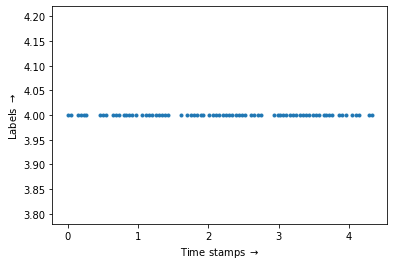

In [17]:
# Video 1
test_vid = data_path + 'datapoint_1.txt'
test_vid = load_X(test_vid)
one_hot_predictions = sess.run([pred], feed_dict={x: test_vid})
timestamp = np.loadtxt(data_path + 'timestamp1.txt')

v = np.squeeze(np.array(one_hot_predictions))
y = np.argmax(np.squeeze(v), axis=1)
temp = np.concatenate((timestamp.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
action = ["Detect Clapping Hands"]
with open('video1.json', 'w') as json_file:
  json.dump(action, json_file)
  json.dump(LABELS, json_file)
  json.dump(temp.T.tolist(), json_file)

plt.plot(timestamp, y, '.')
plt.xlabel(r'Time stamps $\rightarrow$')
plt.ylabel(r'Labels $\rightarrow$')
plt.savefig('Test1.jpeg')

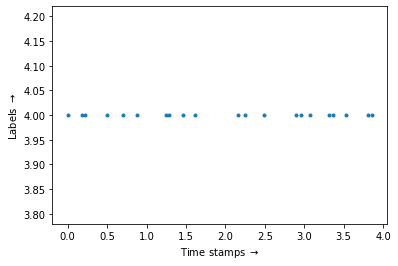

In [18]:
# Video 2
test_vid = data_path + 'datapoint_2.txt'
test_vid = load_X(test_vid)
one_hot_predictions = sess.run([pred], feed_dict={x: test_vid})
timestamp = np.loadtxt(data_path + 'timestamp2.txt')

v = np.squeeze(np.array(one_hot_predictions))
y = np.argmax(np.squeeze(v), axis=1)
temp = np.concatenate((timestamp.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
action = ["Detect Clapping Hands"]
with open('video2.json', 'w') as json_file:
  json.dump(action, json_file)
  json.dump(LABELS, json_file)
  json.dump(temp.T.tolist(), json_file)

plt.plot(timestamp, y, '.')
plt.xlabel(r'Time stamps $\rightarrow$')
plt.ylabel(r'Labels $\rightarrow$')
plt.savefig('Test2.jpeg')

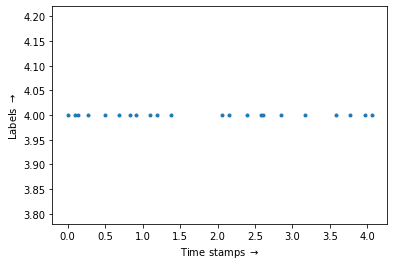

In [19]:
# Video 3
test_vid = data_path + 'datapoint_3.txt'
test_vid = load_X(test_vid)
one_hot_predictions = sess.run([pred], feed_dict={x: test_vid})
timestamp = np.loadtxt(data_path + 'timestamp3.txt')

v = np.squeeze(np.array(one_hot_predictions))
y = np.argmax(np.squeeze(v), axis=1)
temp = np.concatenate((timestamp.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
action = ["Detect Clapping Hands"]
with open('video3.json', 'w') as json_file:
  json.dump(action, json_file)
  json.dump(LABELS, json_file)
  json.dump(temp.T.tolist(), json_file)

plt.plot(timestamp, y, '.')
plt.xlabel(r'Time stamps $\rightarrow$')
plt.ylabel(r'Labels $\rightarrow$')
plt.savefig('Test3.jpeg')

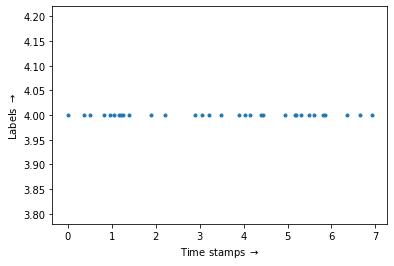

In [20]:
# Video 4
test_vid = data_path + 'datapoint_4.txt'
test_vid = load_X(test_vid)
one_hot_predictions = sess.run([pred], feed_dict={x: test_vid})
timestamp = np.loadtxt(data_path + 'timestamp4.txt')

v = np.squeeze(np.array(one_hot_predictions))
y = np.argmax(np.squeeze(v), axis=1)
temp = np.concatenate((timestamp.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
action = ["Detect Clapping Hands"]
with open('video4.json', 'w') as json_file:
  json.dump(action, json_file)
  json.dump(LABELS, json_file)
  json.dump(temp.T.tolist(), json_file)

plt.plot(timestamp, y, '.')
plt.xlabel(r'Time stamps $\rightarrow$')
plt.ylabel(r'Labels $\rightarrow$')
plt.savefig('Test4.jpeg')

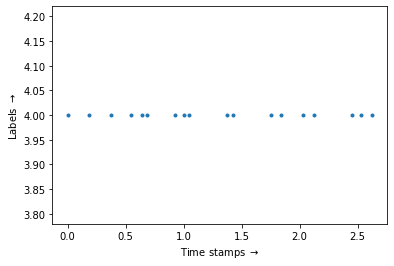

In [21]:
# Video 5
test_vid = data_path + 'datapoint_5.txt'
test_vid = load_X(test_vid)
one_hot_predictions = sess.run([pred], feed_dict={x: test_vid})
timestamp = np.loadtxt(data_path + 'timestamp5.txt')

v = np.squeeze(np.array(one_hot_predictions))
y = np.argmax(np.squeeze(v), axis=1)
temp = np.concatenate((timestamp.reshape((-1, 1)), y.reshape((-1, 1))), axis=1)
action = ["Detect Clapping Hands"]
with open('video5.json', 'w') as json_file:
  json.dump(action, json_file)
  json.dump(LABELS, json_file)
  json.dump(temp.T.tolist(), json_file)

plt.plot(timestamp, y, '.')
plt.xlabel(r'Time stamps $\rightarrow$')
plt.ylabel(r'Labels $\rightarrow$')
plt.savefig('Test5.jpeg')